## Individual Assignment: Machine Learning Tutorial

## Understanding Oversmoothing in Graph Neural Networks  
### A Visual and Intuitive Tutorial  
**Author:** Sumayya  

**Course:** 7PAM2021-0901-2025 - Machine Learning and Neural Networks 

**Date:** 11-12-2025 

**Student ID:** 24069633

**GitHub Repository:** https://github.com/Sumayya22/GNN-Oversmoothing-Tutorial.git

This notebook demonstrates the phenomenon of **oversmoothing** in Graph Neural Networks (GNNs).  
We implement a Graph Convolutional Network (GCN) *from scratch* using only PyTorch,  
which makes the entire notebook fully compatible with Windows/Anaconda/Jupyter setups.

Oversmoothing refers to the collapse of node embeddings into indistinguishable values as  
the number of message-passing layers increases.

**This notebook:**
- Generates a synthetic graph with clear communities  
- Implements a custom GCN layer manually  
- Runs message passing for depths 1–32  
- Visualizes how embeddings collapse over depth  
- Saves all figures into a `figures/` folder   

## Why Study Oversmoothing?

Graph Neural Networks (GNNs) pass messages between nodes.  
This is powerful — but repeated message passing causes **node embeddings to become too similar**,  
eventually collapsing into a single point.

This phenomenon is known as **oversmoothing**.

Oversmoothing is one of the *most important limitations* of modern GNNs:
- Deep GNNs lose discriminative information  
- Classification performance degrades  
- Communities become indistinguishable  
- The network acts like a low-pass filter  

This notebook **visually demonstrates oversmoothing** step-by-step.

In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import random
import os

# Create figures folder
os.makedirs("figures", exist_ok=True)

# Fix all random seeds for full reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Optional GPU seed (safe check)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Setup complete — imports loaded, folder created, seeds fixed.")


Setup complete — imports loaded, folder created, seeds fixed.


## Step 1: Generate a Synthetic Community Graph

To clearly demonstrate oversmoothing, we use a **Stochastic Block Model (SBM)** graph.
This graph contains 4 communities with strong internal connections and weak external connections.

Each community will act as a distinct **class**.  
If embeddings collapse, these classes become impossible to distinguish.


In [151]:
def generate_community_graph(num_communities=4, nodes_per_comm=30, p_intra=0.8, p_inter=0.02):
    sizes = [nodes_per_comm] * num_communities

    probs = np.full((num_communities, num_communities), p_inter)
    np.fill_diagonal(probs, p_intra)

    G = nx.stochastic_block_model(sizes, probs, seed=42)

    # Node features: 8-dimensional random features
    X = np.random.randn(G.number_of_nodes(), 8).astype(np.float32)

    # Labels by community
    labels = []
    for i, size in enumerate(sizes):
        labels += [i] * size
    labels = np.array(labels)

    return G, X, labels

G, X, labels = generate_community_graph()


## Step 2: Visualise the Graph Structure

The graph contains four distinct communities  
with dense internal edges and sparse external edges.

This plot will be included in the final PDF tutorial.


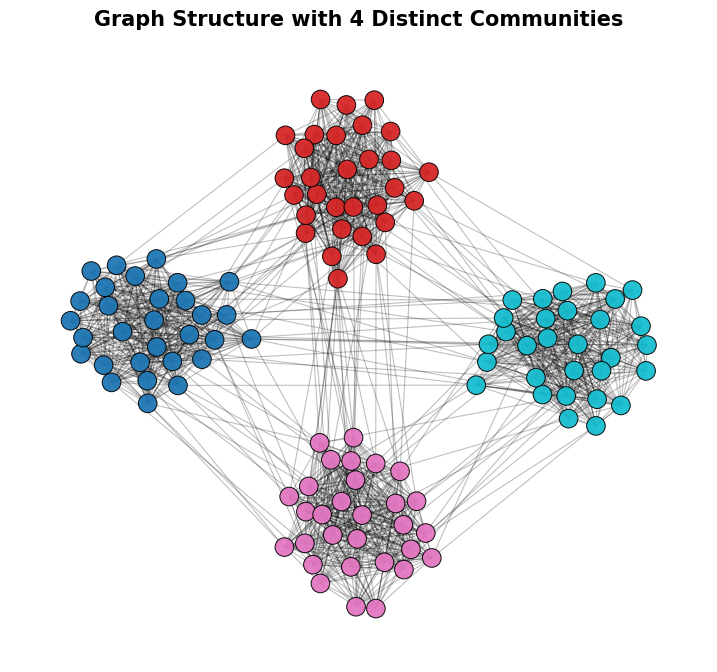

In [153]:
plt.figure(figsize=(9, 8))

# Spring layout with improved spacing
pos = nx.spring_layout(G, seed=42, k=0.35, iterations=200)

# Draw nodes with high clarity
nx.draw_networkx_nodes(
    G, pos,
    node_color=labels,
    cmap="tab10",
    node_size=180,
    edgecolors="black",      # outline for clarity
    linewidths=0.7,
    alpha=0.95
)

# Draw edges with light transparency
nx.draw_networkx_edges(
    G, pos,
    alpha=0.25,
    width=0.8
)

plt.title(
    "Graph Structure with 4 Distinct Communities",
    fontsize=15,
    fontweight='bold',
    pad=15
)

plt.axis('off')
plt.savefig("figures/graph_structure.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


## Step 3: Implement a Graph Convolution Layer (GCN) Manually

A GCN layer performs:

\[
H^{(k+1)} = \sigma(\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H^{(k)} W)
\]

Where:
- \( \tilde{A} \) = adjacency matrix with self-loops  
- \( \tilde{D} \) = degree matrix  
- \( H^{(k)} \) = node embeddings  
- \( W \) = learnable weight matrix  

We implement this manually using PyTorch.



In [155]:
def normalize_adjacency(A):
    A = A + np.eye(A.shape[0])  # add self-loops
    D = np.diag(1.0 / np.sqrt(A.sum(axis=1)))
    return D @ A @ D


A = nx.to_numpy_array(G)
A_norm = normalize_adjacency(A)

A_norm = torch.tensor(A_norm, dtype=torch.float32)


class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_dim, out_dim) * 0.1)

    def forward(self, H):
        return A_norm @ H @ self.weight


## Step 4: Build a Shallow GCN for Initial Features

We train a **2-layer GCN** so that we start with meaningful embeddings  
before running deep message passing experiments.


In [170]:
class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.g1 = GCNLayer(in_dim, hidden_dim)
        self.g2 = GCNLayer(hidden_dim, out_dim)

    def forward(self, H):
        H = F.relu(self.g1(H))
        H = self.g2(H)
        return H


# Convert features and labels to PyTorch tensors
X_torch = torch.tensor(X)
labels_torch = torch.tensor(labels, dtype=torch.long)


model = GCN(in_dim=8, hidden_dim=32, out_dim=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(300):
    optimizer.zero_grad()
    out = model(X_torch)
    loss = F.cross_entropy(out, labels_torch)
    loss.backward()
    optimizer.step()

print("Training complete. Final loss:", loss.item())


Training complete. Final loss: 0.0016714629018679261


## Step 5: Oversmoothing Experiment — Increasing Message Passing Depth

We now propagate embeddings with depths:

**1, 2, 4, 8, 16, 32 layers**

We do **not** train the deep models.  
Oversmoothing is a structural effect, not a training effect.

For each depth:
1. Apply GCNLayer repeatedly  
2. Extract embeddings  
3. Use PCA to reduce to 2D  
4. Plot and save


In [159]:
def run_depth(H, depth):
    layer = GCNLayer(32, 32)  # same-size mapping layer
    torch.nn.init.xavier_uniform_(layer.weight)

    H_out = H.clone()
    for _ in range(depth):
        H_out = F.relu(layer(H_out))
    return H_out.detach().numpy()


with torch.no_grad():
    H0 = F.relu(model.g1(X_torch))  # initial learned embeddings

embeddings = {d: run_depth(H0, d) for d in [1, 2, 4, 8, 16, 32]}


## Step 6: Visualise Embeddings with PCA


In [166]:
def plot_embeddings(emb, labels, depth):
    pca = PCA(n_components=2)
    emb2d = pca.fit_transform(emb)

    plt.figure(figsize=(8, 7))

    # Distinct markers per class
    markers = ['o', 's', 'D', '^', 'v', 'P', '*']

    # High-contrast, colorblind-friendly palette
    colors = ['#1f78b4', '#33a02c', '#e31a1c', '#6a3d9a', '#ff7f00', '#b15928', '#a6cee3']

    unique_labels = np.unique(labels)

    for i, lab in enumerate(unique_labels):
        idx = labels == lab
        plt.scatter(
            emb2d[idx, 0],
            emb2d[idx, 1],
            s=80,                    # larger point size
            marker=markers[i % len(markers)],
            color=colors[i % len(colors)],
            edgecolor='black',       # outline makes points look sharper
            linewidth=0.6,
            alpha=0.85,
            label=f"Class {lab}"
        )

    plt.title(f"PCA Embeddings After {depth} Message-Passing Layers", fontsize=14, fontweight='bold')
    plt.xlabel("PCA Component 1", fontsize=12)
    plt.ylabel("PCA Component 2", fontsize=12)
    plt.grid(alpha=0.3, linestyle='--')
    plt.legend()
    plt.savefig(f"figures/embeddings_layer{depth}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()



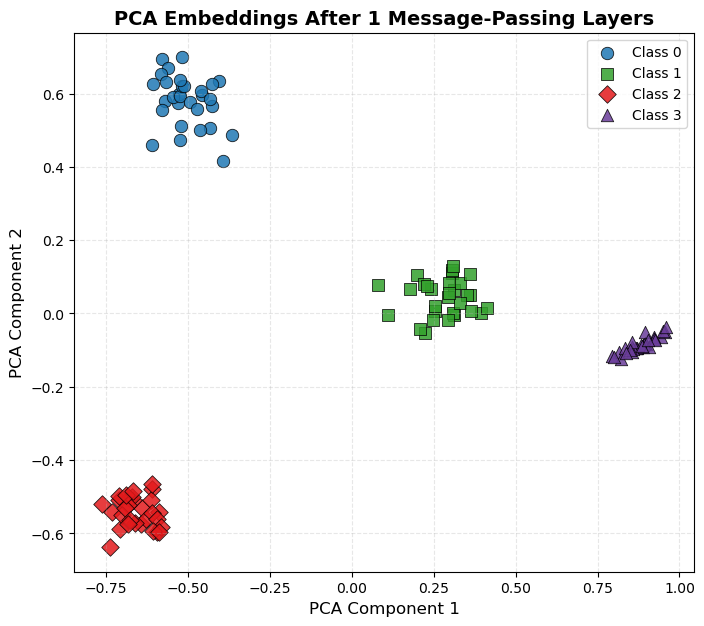

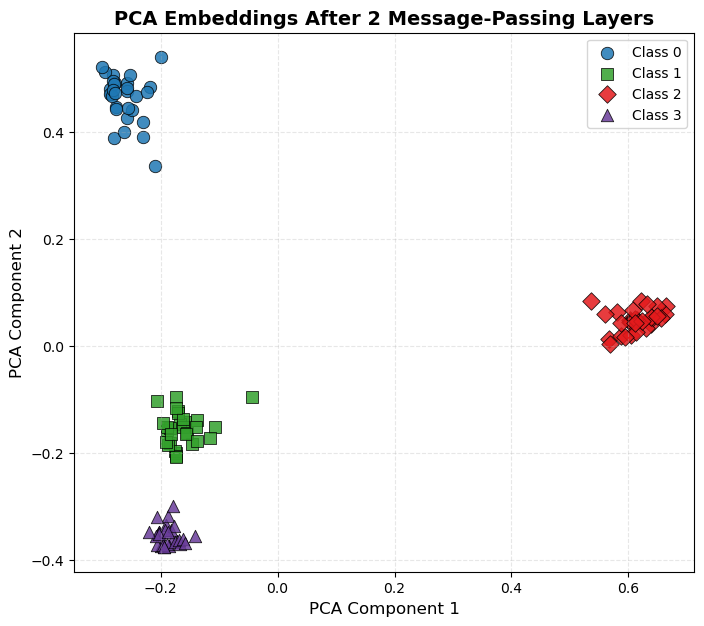

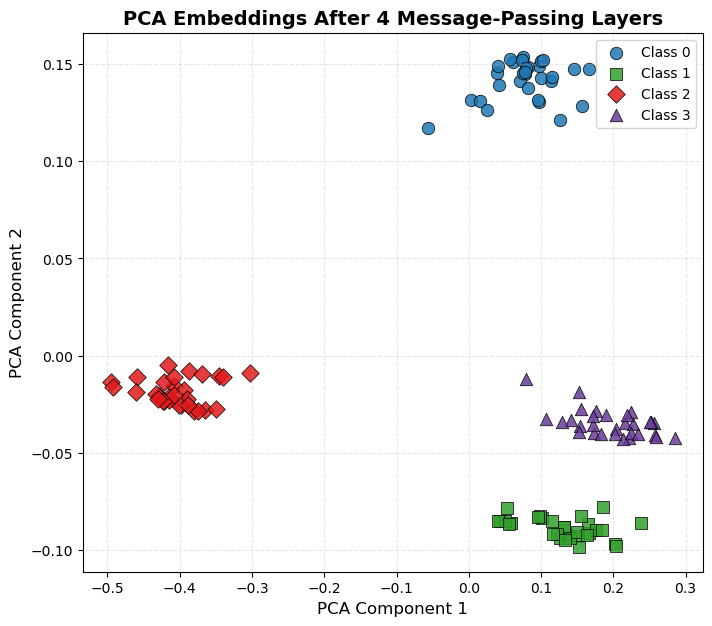

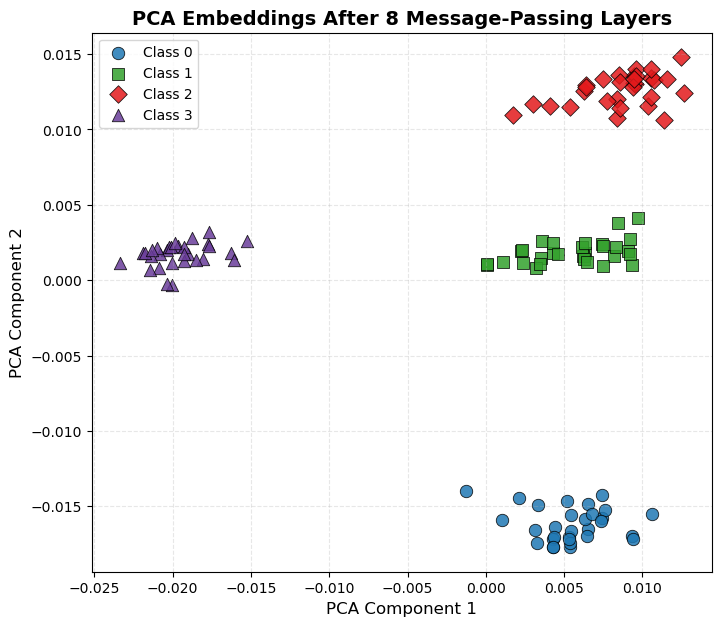

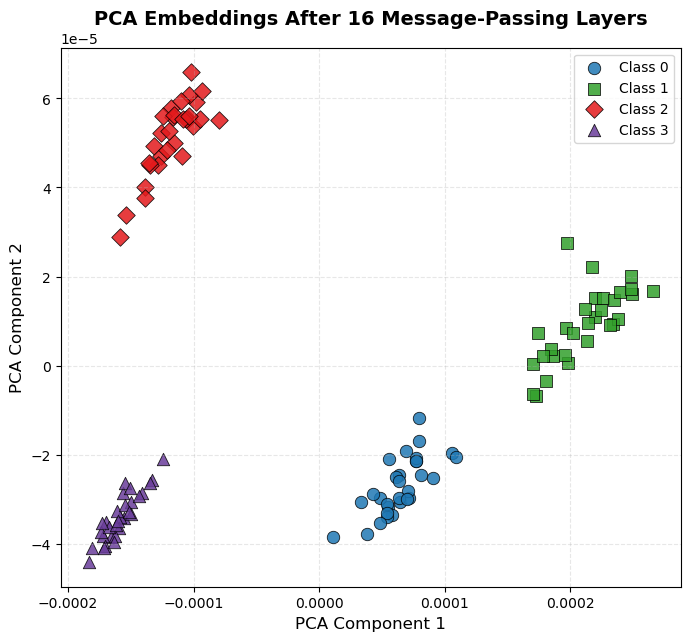

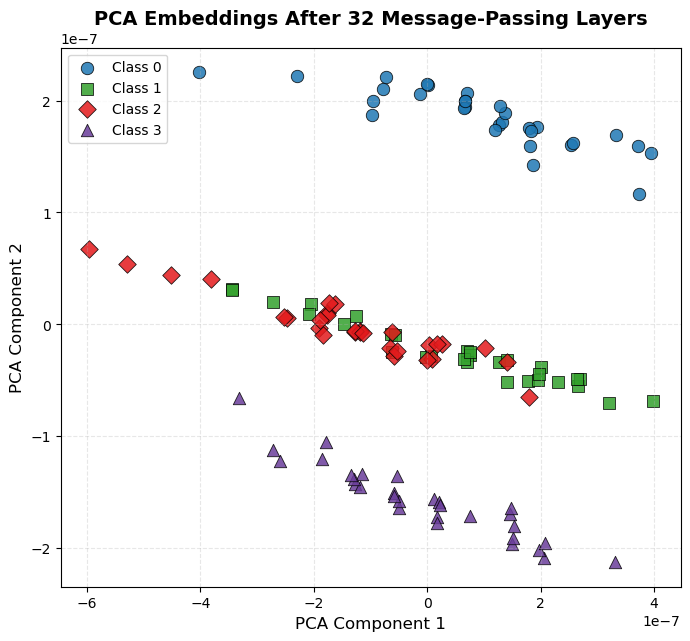

In [168]:
for d, emb in embeddings.items():
    plot_embeddings(emb, labels, d)


## Notebook Complete

All figures referenced in the PDF tutorial are now generated.

You can find them in:



In [ ]:
figures/
├── graph_structure.png
├── embeddings_layer1.png
├── embeddings_layer2.png
├── embeddings_layer4.png
├── embeddings_layer8.png
├── embeddings_layer16.png
└── embeddings_layer32.png